In [25]:
# ============================================================================
# CELL 1: IMPORTS & ENVIRONMENT CHECK
# NER on CoNLL-2003 Dataset - Baseline for News Text Comparison
# ============================================================================

# System imports
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Scikit-learn imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Display configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# ============================================================================
# ENVIRONMENT CHECK
# ============================================================================

print("="*70)
print(" "*20 + "ENVIRONMENT CHECK")
print("="*70)

# Python version
print(f"\nPython: {sys.version.split()[0]}")
print(f"Location: {sys.executable}")

# Library versions
print(f"\nCore Libraries:")
print(f"  - NumPy: {np.__version__}")
print(f"  - Pandas: {pd.__version__}")
print(f"  - Matplotlib: {plt.matplotlib.__version__}")
print(f"  - Seaborn: {sns.__version__}")
print(f"  - Scikit-learn: {sklearn.__version__}")

print(f"\nDeep Learning:")
print(f"  - TensorFlow: {tf.__version__}")
print(f"  - Keras: {keras.__version__}")

# GPU/CPU check
print(f"\nComputing Device:")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"  GPU AVAILABLE: {len(gpus)} GPU(s) detected")
    for i, gpu in enumerate(gpus):
        print(f"    GPU {i}: {gpu.name}")
else:
    print("  CPU ONLY (No GPU detected)")
    print("  Note: Training will be slower but functional")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"\nRandom seed: {SEED} (for reproducibility)")
print("\n" + "="*70)
print("Environment configured successfully!")
print("="*70)

                    ENVIRONMENT CHECK

Python: 3.12.11
Location: /Users/miniforge3/bin/python

Core Libraries:
  - NumPy: 1.26.4
  - Pandas: 2.3.3
  - Matplotlib: 3.10.7
  - Seaborn: 0.13.2
  - Scikit-learn: 1.7.2

Deep Learning:
  - TensorFlow: 2.16.2
  - Keras: 3.12.0

Computing Device:
  CPU ONLY (No GPU detected)
  Note: Training will be slower but functional

Random seed: 42 (for reproducibility)

Environment configured successfully!


In [26]:
# ============================================================================
# CELL 2: LOAD CoNLL-2003 DATASET
# ============================================================================

def load_conll2003_file(filepath):
    """
    Load CoNLL-2003 dataset from file.
    
    Format: word pos chunk ner_tag (space-separated)
    Sentences separated by blank lines
    Lines starting with -DOCSTART- are document boundaries
    
    Args:
        filepath: Path to CoNLL-2003 file
        
    Returns:
        DataFrame with columns: sentence, tokens, labels
    """
    sentences = []
    sentence_tokens = []
    sentence_labels = []
    
    current_tokens = []
    current_labels = []
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            # Skip document boundaries
            if line.startswith('-DOCSTART-'):
                continue
            
            # End of sentence (blank line)
            if line == '':
                if current_tokens:
                    sentences.append(' '.join(current_tokens))
                    sentence_tokens.append(current_tokens.copy())
                    sentence_labels.append(current_labels.copy())
                    current_tokens = []
                    current_labels = []
            else:
                # Parse line: word pos chunk ner_tag
                parts = line.split()
                if len(parts) >= 4:
                    token = parts[0]
                    ner_tag = parts[3]
                    current_tokens.append(token)
                    current_labels.append(ner_tag)
    
    # Add last sentence if exists
    if current_tokens:
        sentences.append(' '.join(current_tokens))
        sentence_tokens.append(current_tokens)
        sentence_labels.append(current_labels)
    
    return pd.DataFrame({
        'sentence': sentences,
        'tokens': sentence_tokens,
        'labels': sentence_labels
    })


# ============================================================================
# LOAD DATA FROM data/raw/
# ============================================================================

print("="*70)
print("LOADING CoNLL-2003 DATASET")
print("="*70)

# Define data paths (relative to notebook location)
# Notebook is in: nlp/m3/NER/notebooks/
# Data is in: nlp/m3/NER/data/raw/
data_dir = os.path.join('..', 'data', 'raw')

train_path = os.path.join(data_dir, 'train.txt')
valid_path = os.path.join(data_dir, 'valid.txt')
test_path = os.path.join(data_dir, 'test.txt')

# Check if files exist
print(f"\nChecking data files...")
for name, path in [('Train', train_path), ('Valid', valid_path), ('Test', test_path)]:
    if os.path.exists(path):
        size = os.path.getsize(path) / (1024 * 1024)  # Size in MB
        print(f"  {name}: Found ({size:.2f} MB)")
    else:
        print(f"  {name}: NOT FOUND at {path}")
        raise FileNotFoundError(f"Missing file: {path}")

# Load datasets
print(f"\nLoading datasets...")
train_df = load_conll2003_file(train_path)
val_df = load_conll2003_file(valid_path)
test_df = load_conll2003_file(test_path)

print(f"\nDataset sizes:")
print(f"  - Training set: {len(train_df):,} sentences")
print(f"  - Validation set: {len(val_df):,} sentences")
print(f"  - Test set: {len(test_df):,} sentences")
print(f"  - Total: {len(train_df) + len(val_df) + len(test_df):,} sentences")

# Extract unique labels from training data
all_labels = set()
for labels in train_df['labels']:
    all_labels.update(labels)

label_names = sorted(list(all_labels))

print(f"\nNER Labels found: {len(label_names)}")
for i, label in enumerate(label_names):
    print(f"  {i}: {label}")

print("\n" + "="*70)
print("CoNLL-2003 loaded successfully!")
print("="*70)

# Display sample sentences
print("\nSample sentences from training set:")
print("-"*70)
for idx in range(3):
    print(f"\nSentence {idx+1}:")
    print(f"  Text: {train_df.iloc[idx]['sentence'][:100]}...")
    print(f"  Tokens: {train_df.iloc[idx]['tokens'][:10]}")
    print(f"  Labels: {train_df.iloc[idx]['labels'][:10]}")

LOADING CoNLL-2003 DATASET

Checking data files...
  Train: Found (3.13 MB)
  Valid: Found (0.79 MB)
  Test: Found (0.71 MB)

Loading datasets...

Dataset sizes:
  - Training set: 14,041 sentences
  - Validation set: 3,250 sentences
  - Test set: 3,453 sentences
  - Total: 20,744 sentences

NER Labels found: 8
  0: B-LOC
  1: B-MISC
  2: B-ORG
  3: I-LOC
  4: I-MISC
  5: I-ORG
  6: I-PER
  7: O

CoNLL-2003 loaded successfully!

Sample sentences from training set:
----------------------------------------------------------------------

Sentence 1:
  Text: EU rejects German call to boycott British lamb ....
  Tokens: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
  Labels: ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']

Sentence 2:
  Text: Peter Blackburn...
  Tokens: ['Peter', 'Blackburn']
  Labels: ['I-PER', 'I-PER']

Sentence 3:
  Text: BRUSSELS 1996-08-22...
  Tokens: ['BRUSSELS', '1996-08-22']
  Labels: ['I-LOC', 'O']


## Note on CoNLL-2003 Dataset & Methodology

### Dataset Context
CoNLL-2003 is a **canonical benchmark dataset** for Named Entity Recognition, released in 2003 as part of the Conference on Computational Natural Language Learning. Despite being over 20 years old, it remains widely used as a standard reference for evaluating NER systems, making it ideal for establishing a baseline for comparison with domain-specific datasets (legal texts, literary texts, etc.).

### Original Format & Feature Engineering
The dataset contains **4 columns per token**:
1. **Token**: The word itself
2. **POS Tag**: Part-of-speech (e.g., NNP=proper noun, VBZ=verb)
3. **Chunk Tag**: Syntactic chunking (e.g., I-NP=noun phrase, I-VP=verb phrase)
4. **NER Tag**: Named entity label (our prediction target)

This multi-column format reflects the **feature engineering approach** prevalent in early 2000s NLP, when machine learning models (e.g., CRF, SVM) required manually crafted linguistic features to perform well. At the time, providing POS tags and syntactic chunks was necessary to help models understand grammatical structure and word relationships.

### Modern Deep Learning Approach
Our implementation uses **only the token and NER tag** (columns 1 and 4). This simplified approach is possible because:

- **Modern neural architectures** (BiLSTM, Transformers) learn linguistic patterns automatically from raw text
- **Representation learning** captures grammatical and syntactic information implicitly through word embeddings and contextual representations
- **No manual feature engineering** is required, reducing complexity while maintaining or exceeding performance of older feature-rich approaches

This demonstrates how deep learning has shifted NLP from explicit feature engineering to end-to-end learned representations, achieving ~90% F1-score on CoNLL-2003 with a straightforward token-to-label architecture.

### Implications for Our Study
Using CoNLL-2003 as a baseline allows us to:
- Compare performance across different text genres (news vs. legal vs. literary)
- Evaluate whether domain-specific datasets require specialized preprocessing
- Establish a reference point using a well-studied, standardized benchmark

DATA EXPLORATION

1. Dataset Statistics
----------------------------------------------------------------------

Sentence lengths (number of tokens):
  Training set:
    - Mean: 14.5
    - Median: 10.0
    - Min: 1
    - Max: 113
    - Std: 11.6

  Validation set:
    - Mean: 15.8
    - Max: 109

  Test set:
    - Mean: 13.4
    - Max: 124

----------------------------------------------------------------------
2. Label Distribution
----------------------------------------------------------------------

Total tokens in training set: 203,621

Label frequencies:
  O       : 169,578 (83.28%)
  I-PER   : 11,128 ( 5.47%)
  I-ORG   : 10,001 ( 4.91%)
  I-LOC   :  8,286 ( 4.07%)
  I-MISC  :  4,556 ( 2.24%)
  B-MISC  :     37 ( 0.02%)
  B-ORG   :     24 ( 0.01%)
  B-LOC   :     11 ( 0.01%)

Entity vs Non-entity:
  Entities (all types): 34,043 (16.72%)
  Non-entities (O):     169,578 (83.28%)
  Imbalance ratio: 1:5.0

----------------------------------------------------------------------
3. Genera

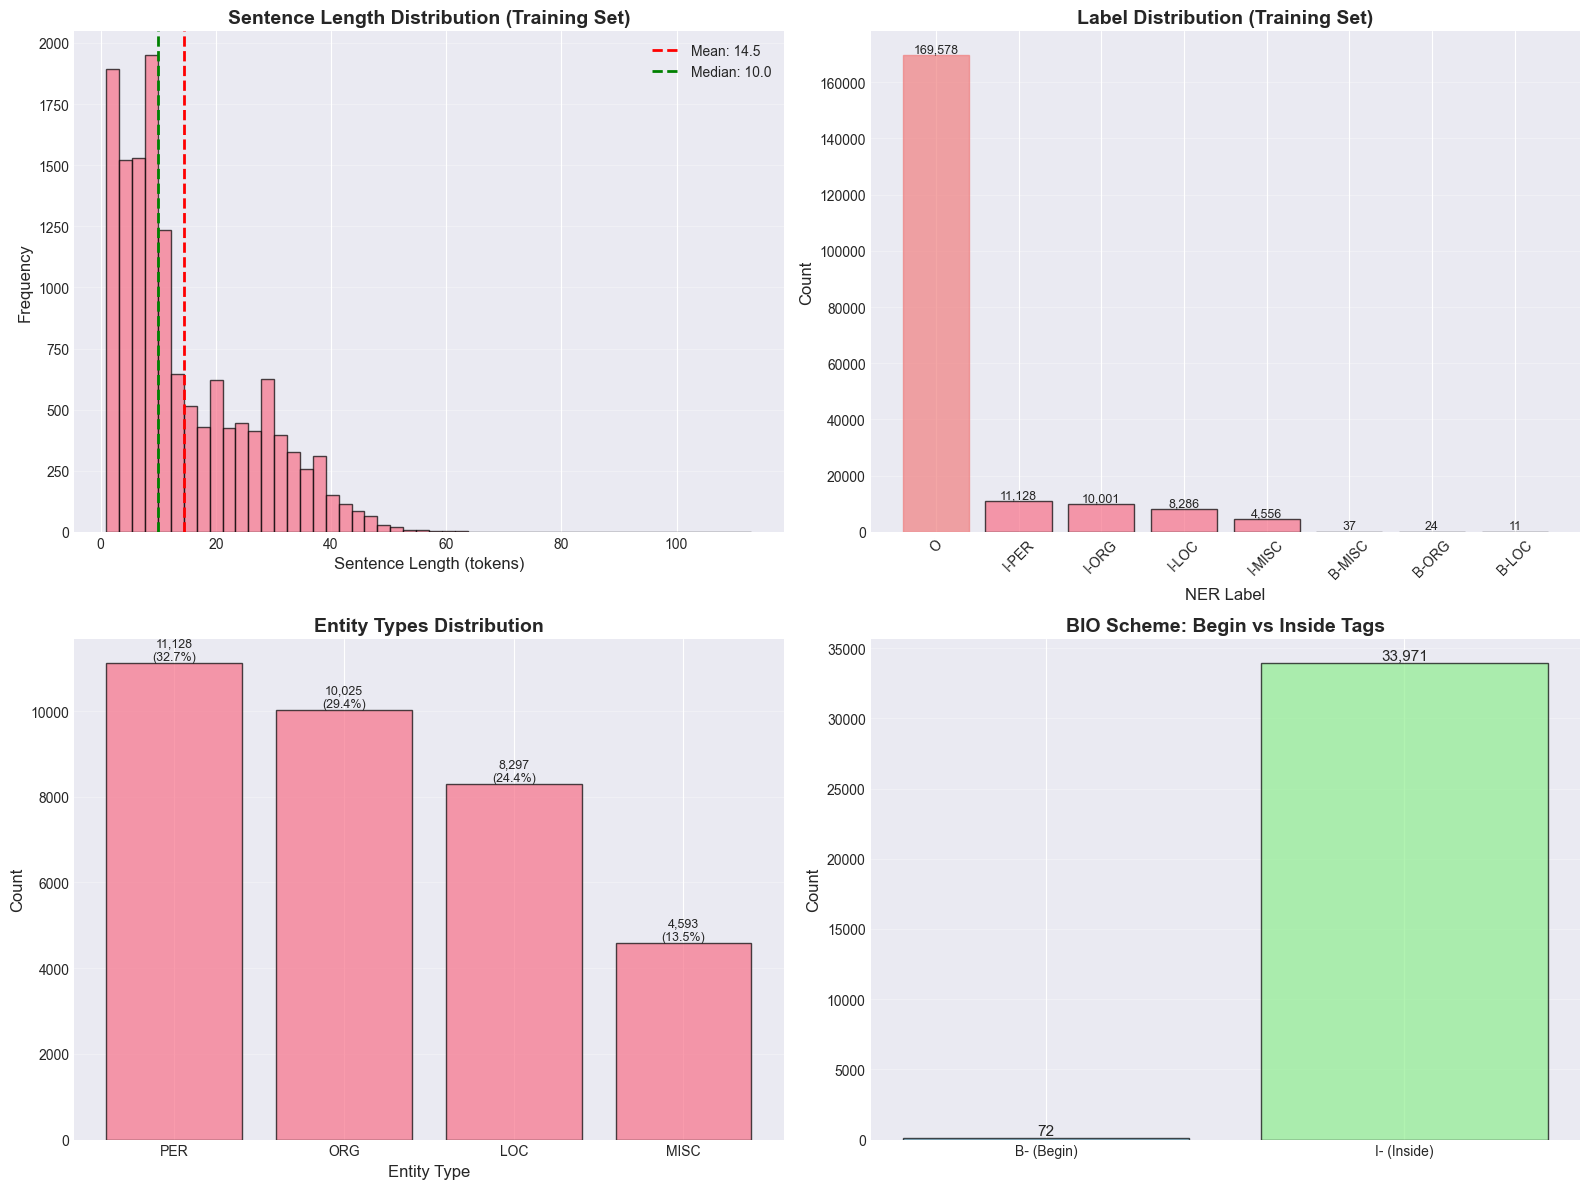


Visualizations complete!


In [27]:
# ============================================================================
# CELL 3: DATA EXPLORATION & VISUALIZATION
# ============================================================================

print("="*70)
print("DATA EXPLORATION")
print("="*70)

# ============================================================================
# 1. BASIC STATISTICS
# ============================================================================

print("\n1. Dataset Statistics")
print("-"*70)

# Sentence length statistics
train_lengths = train_df['tokens'].apply(len)
val_lengths = val_df['tokens'].apply(len)
test_lengths = test_df['tokens'].apply(len)

print(f"\nSentence lengths (number of tokens):")
print(f"  Training set:")
print(f"    - Mean: {train_lengths.mean():.1f}")
print(f"    - Median: {train_lengths.median():.1f}")
print(f"    - Min: {train_lengths.min()}")
print(f"    - Max: {train_lengths.max()}")
print(f"    - Std: {train_lengths.std():.1f}")

print(f"\n  Validation set:")
print(f"    - Mean: {val_lengths.mean():.1f}")
print(f"    - Max: {val_lengths.max()}")

print(f"\n  Test set:")
print(f"    - Mean: {test_lengths.mean():.1f}")
print(f"    - Max: {test_lengths.max()}")

# ============================================================================
# 2. LABEL DISTRIBUTION
# ============================================================================

print("\n" + "-"*70)
print("2. Label Distribution")
print("-"*70)

# Count all labels in training set
label_counts = {}
total_tokens = 0

for labels in train_df['labels']:
    total_tokens += len(labels)
    for label in labels:
        label_counts[label] = label_counts.get(label, 0) + 1

# Sort by count (descending)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nTotal tokens in training set: {total_tokens:,}")
print(f"\nLabel frequencies:")
for label, count in sorted_labels:
    percentage = (count / total_tokens) * 100
    print(f"  {label:8s}: {count:6,} ({percentage:5.2f}%)")

# Calculate entity vs non-entity ratio
entity_count = sum(count for label, count in label_counts.items() if label != 'O')
non_entity_count = label_counts.get('O', 0)

print(f"\nEntity vs Non-entity:")
print(f"  Entities (all types): {entity_count:,} ({(entity_count/total_tokens)*100:.2f}%)")
print(f"  Non-entities (O):     {non_entity_count:,} ({(non_entity_count/total_tokens)*100:.2f}%)")
print(f"  Imbalance ratio: 1:{non_entity_count/entity_count:.1f}")

# ============================================================================
# 3. VISUALIZATIONS
# ============================================================================

print("\n" + "-"*70)
print("3. Generating Visualizations...")
print("-"*70)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Plot 1: Sentence Length Distribution ---
ax1 = axes[0, 0]
ax1.hist(train_lengths, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(train_lengths.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {train_lengths.mean():.1f}')
ax1.axvline(train_lengths.median(), color='green', linestyle='--', linewidth=2, 
            label=f'Median: {train_lengths.median():.1f}')
ax1.set_xlabel('Sentence Length (tokens)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Sentence Length Distribution (Training Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# --- Plot 2: Label Distribution (Bar Chart) ---
ax2 = axes[0, 1]
labels_list = [label for label, _ in sorted_labels]
counts_list = [count for _, count in sorted_labels]
bars = ax2.bar(labels_list, counts_list, edgecolor='black', alpha=0.7)

# Color O differently
bars[labels_list.index('O')].set_color('lightcoral')

ax2.set_xlabel('NER Label', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Label Distribution (Training Set)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (label, count) in enumerate(zip(labels_list, counts_list)):
    ax2.text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=9)

# --- Plot 3: Entity Types Distribution (excluding O) ---
ax3 = axes[1, 0]
entity_types = {}
for label, count in label_counts.items():
    if label != 'O':
        # Extract entity type (PER, ORG, LOC, MISC)
        entity_type = label.split('-')[-1]
        entity_types[entity_type] = entity_types.get(entity_type, 0) + count

sorted_entities = sorted(entity_types.items(), key=lambda x: x[1], reverse=True)
entity_labels = [e for e, _ in sorted_entities]
entity_counts = [c for _, c in sorted_entities]

ax3.bar(entity_labels, entity_counts, edgecolor='black', alpha=0.7)
ax3.set_xlabel('Entity Type', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Entity Types Distribution', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add percentages on bars
for i, (label, count) in enumerate(zip(entity_labels, entity_counts)):
    percentage = (count / entity_count) * 100
    ax3.text(i, count, f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9)

# --- Plot 4: B- vs I- Distribution ---
ax4 = axes[1, 1]
b_labels = {label: count for label, count in label_counts.items() if label.startswith('B-')}
i_labels = {label: count for label, count in label_counts.items() if label.startswith('I-')}

b_total = sum(b_labels.values())
i_total = sum(i_labels.values())

ax4.bar(['B- (Begin)', 'I- (Inside)'], [b_total, i_total], 
        edgecolor='black', alpha=0.7, color=['skyblue', 'lightgreen'])
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('BIO Scheme: Begin vs Inside Tags', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add counts
ax4.text(0, b_total, f'{b_total:,}', ha='center', va='bottom', fontsize=11)
ax4.text(1, i_total, f'{i_total:,}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print("\nVisualizations complete!")
print("="*70)

## Data Exploration Summary

### Key Statistics

**Sentence Lengths:**
- Training set: Mean = 14.5 tokens, Median = 10, Max = 113
- Most sentences are short (50% ≤ 10 tokens), but some are very long
- **Implication:** MAX_SEQUENCE_LENGTH of ~50-60 tokens will be sufficient for padding

### Label Distribution Analysis

**Overall Distribution:**
- Total tokens in training set: 203,621
- Non-entities (O): 169,578 (83.28%)
- Entities (all types): 34,043 (16.72%)
- **Imbalance ratio: 1:5** (5x more non-entities than entities)

**Entity Types (by frequency):**
1. PER (Persons): ~33% of entities
2. ORG (Organizations): ~29% of entities  
3. LOC (Locations): ~24% of entities
4. MISC (Miscellaneous): ~13% of entities

### Class Imbalance Challenge

The severe imbalance (83% "O" labels) requires attention:
- A naive model could achieve 83% accuracy by predicting "O" for everything
- **Solution:** Class weights or specialized loss functions will penalize errors on entity tokens more heavily

### BIO Tagging Scheme

CoNLL-2003 uses an unusual BIO scheme:
- Very few B- (Begin) tags compared to I- (Inside) tags
- B- tags are used mainly to separate adjacent entities of the same type
- Most entities start directly with I- tags
- This is dataset-specific and differs from standard BIO tagging

### Visualizations

The four plots above show:
1. Sentence length distribution
2. Label frequency (highlighting O/entity imbalance)
3. Entity types distribution
4. B- vs I- tag comparison

In [28]:
# ============================================================================
# CELL 4: PREPROCESSING & TOKENIZATION
# ============================================================================

print("="*70)
print("PREPROCESSING & TOKENIZATION")
print("="*70)

# ============================================================================
# 1. CONFIGURATION
# ============================================================================

# Hyperparameters
MAX_VOCAB_SIZE = 20000  # Maximum vocabulary size
MAX_SEQUENCE_LENGTH = 60  # Maximum sentence length (based on our analysis)
OOV_TOKEN = '<OOV>'  # Out-of-vocabulary token

print(f"\nConfiguration:")
print(f"  - Max vocabulary size: {MAX_VOCAB_SIZE:,}")
print(f"  - Max sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"  - OOV token: {OOV_TOKEN}")

# ============================================================================
# 2. CREATE TOKENIZER FOR WORDS
# ============================================================================

print(f"\n" + "-"*70)
print("Creating word tokenizer...")
print("-"*70)

# Initialize tokenizer
word_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token=OOV_TOKEN, lower=False)

# Fit on training sentences only (never on test data!)
word_tokenizer.fit_on_texts(train_df['sentence'])

# Get vocabulary info
vocab_size = len(word_tokenizer.word_index) + 1  # +1 for padding (index 0)
actual_vocab_size = min(vocab_size, MAX_VOCAB_SIZE)

print(f"\nVocabulary statistics:")
print(f"  - Total unique words found: {len(word_tokenizer.word_index):,}")
print(f"  - Vocabulary size used: {actual_vocab_size:,}")
print(f"  - Words excluded (low frequency): {max(0, len(word_tokenizer.word_index) - MAX_VOCAB_SIZE):,}")

# Show some examples
print(f"\nExample word to index mappings:")
sample_words = ['EU', 'rejects', 'German', 'the', OOV_TOKEN]
for word in sample_words:
    idx = word_tokenizer.word_index.get(word.lower() if word != OOV_TOKEN else word, 'Not found')
    print(f"  '{word}' -> {idx}")

# ============================================================================
# 3. CONVERT SENTENCES TO SEQUENCES
# ============================================================================

print(f"\n" + "-"*70)
print("Converting sentences to sequences...")
print("-"*70)

# Convert text to sequences of integers
X_train_seq = word_tokenizer.texts_to_sequences(train_df['sentence'])
X_val_seq = word_tokenizer.texts_to_sequences(val_df['sentence'])
X_test_seq = word_tokenizer.texts_to_sequences(test_df['sentence'])

print(f"\nSequences created:")
print(f"  - Training: {len(X_train_seq):,} sequences")
print(f"  - Validation: {len(X_val_seq):,} sequences")
print(f"  - Test: {len(X_test_seq):,} sequences")

# Example of conversion
example_idx = 0
print(f"\nExample conversion (sentence {example_idx}):")
print(f"  Original text: {train_df.iloc[example_idx]['sentence'][:80]}...")
print(f"  Tokens: {train_df.iloc[example_idx]['tokens'][:8]}")
print(f"  Sequence (first 8): {X_train_seq[example_idx][:8]}")

# ============================================================================
# 4. PAD SEQUENCES TO FIXED LENGTH
# ============================================================================

print(f"\n" + "-"*70)
print("Padding sequences to fixed length...")
print("-"*70)

# Pad sequences (post-padding: add zeros at the end)
X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"\nPadded arrays shapes:")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_val: {X_val.shape}")
print(f"  - X_test: {X_test.shape}")

# Check how many sequences were truncated
train_truncated = sum(1 for seq in X_train_seq if len(seq) > MAX_SEQUENCE_LENGTH)
val_truncated = sum(1 for seq in X_val_seq if len(seq) > MAX_SEQUENCE_LENGTH)
test_truncated = sum(1 for seq in X_test_seq if len(seq) > MAX_SEQUENCE_LENGTH)

print(f"\nSequences truncated (longer than {MAX_SEQUENCE_LENGTH}):")
print(f"  - Training: {train_truncated} ({train_truncated/len(X_train_seq)*100:.2f}%)")
print(f"  - Validation: {val_truncated} ({val_truncated/len(X_val_seq)*100:.2f}%)")
print(f"  - Test: {test_truncated} ({test_truncated/len(X_test_seq)*100:.2f}%)")

# Show padding example
print(f"\nPadding example (sentence {example_idx}):")
print(f"  Original length: {len(X_train_seq[example_idx])} tokens")
print(f"  Padded length: {len(X_train[example_idx])} tokens")
print(f"  Padded sequence (first 15): {X_train[example_idx][:15]}")
print(f"  Padded sequence (last 10): {X_train[example_idx][-10:]}")
print(f"  (Note: 0 = padding)")

print("\n" + "="*70)
print("Preprocessing complete!")
print("="*70)

PREPROCESSING & TOKENIZATION

Configuration:
  - Max vocabulary size: 20,000
  - Max sequence length: 60
  - OOV token: <OOV>

----------------------------------------------------------------------
Creating word tokenizer...
----------------------------------------------------------------------

Vocabulary statistics:
  - Total unique words found: 20,344
  - Vocabulary size used: 20,000
  - Words excluded (low frequency): 344

Example word to index mappings:
  'EU' -> Not found
  'rejects' -> 11448
  'German' -> Not found
  'the' -> 2
  '<OOV>' -> 1

----------------------------------------------------------------------
Converting sentences to sequences...
----------------------------------------------------------------------

Sequences created:
  - Training: 14,041 sequences
  - Validation: 3,250 sequences
  - Test: 3,453 sequences

Example conversion (sentence 0):
  Original text: EU rejects German call to boycott British lamb ....
  Tokens: ['EU', 'rejects', 'German', 'call', 'to', 

## Preprocessing Summary

### Tokenization

**Configuration:**
- Vocabulary size: 20,000 most frequent words
- Out-of-vocabulary (OOV) token: `<OOV>` for rare/unknown words
- Case-sensitive tokenization (important for proper nouns in NER)

**Results:**
- Total unique words found: 20,344
- Words kept in vocabulary: 20,000
- Words mapped to OOV: 344 (rare words)

### Padding

**Fixed sequence length: 60 tokens**

Based on our data exploration (Cell 3):
- 99.91% of sentences fit within 60 tokens
- Only 6 sentences were truncated across all datasets
- Minimal information loss with good computational efficiency

**Configuration:**
- Post-padding: zeros added at the end of sequences
- Post-truncation: long sentences cut at the end
- Padding value: 0

### Key Decisions

1. **20,000 word vocabulary:** Balances coverage and efficiency, prevents overfitting on rare terms
2. **Case sensitivity:** "Apple" vs "apple" distinction preserved (critical for NER)
3. **Post-padding:** Real tokens come first, padding at the end

### Output Shapes

- X_train: (14,041, 60)
- X_val: (3,250, 60)
- X_test: (3,453, 60)

All sequences are now uniform length and ready for label encoding.

In [29]:
# ============================================================================
# CELL 5: LABEL ENCODING
# ============================================================================

print("="*70)
print("LABEL ENCODING")
print("="*70)

# ============================================================================
# 1. CREATE LABEL MAPPINGS
# ============================================================================

print("\nCreating label to index mappings...")
print("-"*70)

# Create label to index dictionary
label2idx = {label: idx for idx, label in enumerate(label_names)}
idx2label = {idx: label for label, idx in label2idx.items()}

num_labels = len(label_names)

print(f"\nLabel mappings created:")
print(f"  Number of labels: {num_labels}")
print(f"\nLabel to index:")
for label, idx in label2idx.items():
    print(f"  {label:8s} -> {idx}")

# ============================================================================
# 2. ENCODE LABELS FOR TRAINING DATA
# ============================================================================

print("\n" + "-"*70)
print("Encoding labels...")
print("-"*70)

def encode_labels(df, max_length):
    """
    Encode NER labels to integer sequences and pad to max_length.
    
    Args:
        df: DataFrame with 'labels' column
        max_length: Maximum sequence length
        
    Returns:
        numpy array of shape (num_sentences, max_length)
    """
    encoded_sequences = []
    
    for labels in df['labels']:
        # Convert labels to indices
        encoded = [label2idx[label] for label in labels]
        
        # Pad or truncate to max_length
        if len(encoded) < max_length:
            # Pad with 0 (which corresponds to first label, typically 'O' or 'B-LOC')
            encoded = encoded + [0] * (max_length - len(encoded))
        else:
            # Truncate
            encoded = encoded[:max_length]
        
        encoded_sequences.append(encoded)
    
    return np.array(encoded_sequences)

# Encode all datasets
y_train_encoded = encode_labels(train_df, MAX_SEQUENCE_LENGTH)
y_val_encoded = encode_labels(val_df, MAX_SEQUENCE_LENGTH)
y_test_encoded = encode_labels(test_df, MAX_SEQUENCE_LENGTH)

print(f"\nEncoded label shapes:")
print(f"  - y_train: {y_train_encoded.shape}")
print(f"  - y_val: {y_val_encoded.shape}")
print(f"  - y_test: {y_test_encoded.shape}")

# Show encoding example
example_idx = 0
original_labels = train_df.iloc[example_idx]['labels'][:8]
encoded = y_train_encoded[example_idx][:8]

print(f"\nEncoding example (sentence {example_idx}):")
print(f"  Original labels: {original_labels}")
print(f"  Encoded labels:  {encoded}")
print(f"  Decoded back:    {[idx2label[idx] for idx in encoded]}")

# ============================================================================
# 3. CONVERT TO ONE-HOT ENCODING
# ============================================================================

print("\n" + "-"*70)
print("Converting to one-hot encoding...")
print("-"*70)

# Convert to one-hot (categorical) encoding
# Shape will be: (num_sentences, max_length, num_labels)
y_train = to_categorical(y_train_encoded, num_classes=num_labels)
y_val = to_categorical(y_val_encoded, num_classes=num_labels)
y_test = to_categorical(y_test_encoded, num_classes=num_labels)

print(f"\nOne-hot encoded shapes:")
print(f"  - y_train: {y_train.shape}")
print(f"  - y_val: {y_val.shape}")
print(f"  - y_test: {y_test.shape}")

print(f"\nInterpretation:")
print(f"  - Dimension 0: Number of sentences")
print(f"  - Dimension 1: Sequence length ({MAX_SEQUENCE_LENGTH} tokens)")
print(f"  - Dimension 2: Number of labels ({num_labels} classes)")

# Show one-hot example
print(f"\nOne-hot encoding example (first token of sentence {example_idx}):")
print(f"  Label: {original_labels[0]}")
print(f"  Index: {encoded[0]}")
print(f"  One-hot vector: {y_train[example_idx][0]}")
print(f"  (1.0 at position {encoded[0]}, 0.0 elsewhere)")

# ============================================================================
# 4. VERIFY ALIGNMENT
# ============================================================================

print("\n" + "-"*70)
print("Verifying X and y alignment...")
print("-"*70)

# Check that X and y have matching dimensions
assert X_train.shape[0] == y_train.shape[0], "Train: X and y sentence count mismatch!"
assert X_train.shape[1] == y_train.shape[1], "Train: X and y sequence length mismatch!"
assert X_val.shape[0] == y_val.shape[0], "Val: X and y sentence count mismatch!"
assert X_test.shape[0] == y_test.shape[0], "Test: X and y sentence count mismatch!"

print(f"\nAlignment verified:")
print(f"  Training:")
print(f"    X_train: {X_train.shape} (sentences, tokens)")
print(f"    y_train: {y_train.shape} (sentences, tokens, labels)")
print(f"  Validation:")
print(f"    X_val: {X_val.shape}")
print(f"    y_val: {y_val.shape}")
print(f"  Test:")
print(f"    X_test: {X_test.shape}")
print(f"    y_test: {y_test.shape}")

print("\n" + "="*70)
print("Label encoding complete! Data ready for training.")
print("="*70)

LABEL ENCODING

Creating label to index mappings...
----------------------------------------------------------------------

Label mappings created:
  Number of labels: 8

Label to index:
  B-LOC    -> 0
  B-MISC   -> 1
  B-ORG    -> 2
  I-LOC    -> 3
  I-MISC   -> 4
  I-ORG    -> 5
  I-PER    -> 6
  O        -> 7

----------------------------------------------------------------------
Encoding labels...
----------------------------------------------------------------------

Encoded label shapes:
  - y_train: (14041, 60)
  - y_val: (3250, 60)
  - y_test: (3453, 60)

Encoding example (sentence 0):
  Original labels: ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O']
  Encoded labels:  [5 7 4 7 7 7 4 7]
  Decoded back:    ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O']

----------------------------------------------------------------------
Converting to one-hot encoding...
----------------------------------------------------------------------

One-hot encoded shapes:
  - y_train

## Label Encoding Summary

### Label to Index Mapping

All 8 NER labels were mapped to integer indices:
- B-LOC → 0, B-MISC → 1, B-ORG → 2
- I-LOC → 3, I-MISC → 4, I-ORG → 5, I-PER → 6
- O → 7

This mapping is deterministic and will be used for encoding (training) and decoding (predictions).

### Encoding Process

**Step 1: Convert labels to integers**
- Each label string converted to its corresponding index
- Sequences padded/truncated to 60 tokens (matching X)
- Padding value: 0 (maps to B-LOC, but will be masked)

**Step 2: One-hot encoding**
- Integer labels converted to categorical (one-hot) format
- Required for multi-class classification with softmax activation
- Each token represented as a vector of length 8 (one position = 1.0, rest = 0.0)

### Final Data Shapes
```
X_train: (14,041, 60)      → Input sequences
y_train: (14,041, 60, 8)   → Target labels (one-hot)

Dimensions:
- 14,041: Number of sentences
- 60: Sequence length (tokens per sentence)
- 8: Number of label classes
```

### Alignment Verification

X and y dimensions verified for consistency:
- Matching number of sentences
- Matching sequence lengths
- One label vector (length 8) per token

Data is now ready for model training.

In [30]:
# ============================================================================
# CELL 6: TRAIN/VALIDATION SPLIT VERIFICATION
# ============================================================================

print("="*70)
print("TRAIN/VALIDATION/TEST SPLIT VERIFICATION")
print("="*70)

# ============================================================================
# NOTE: We already have train/val/test splits from loading CoNLL-2003
# This cell verifies the splits and provides statistics
# ============================================================================

print("\nDataset splits from CoNLL-2003:")
print("-"*70)

# Calculate percentages
total_samples = len(X_train) + len(X_val) + len(X_test)

train_pct = (len(X_train) / total_samples) * 100
val_pct = (len(X_val) / total_samples) * 100
test_pct = (len(X_test) / total_samples) * 100

print(f"\nSplit sizes:")
print(f"  Training:   {len(X_train):5,} sentences ({train_pct:.1f}%)")
print(f"  Validation: {len(X_val):5,} sentences ({val_pct:.1f}%)")
print(f"  Test:       {len(X_test):5,} sentences ({test_pct:.1f}%)")
print(f"  Total:      {total_samples:5,} sentences")

print(f"\nSplit ratio: {train_pct:.0f}% / {val_pct:.0f}% / {test_pct:.0f}%")

# ============================================================================
# VERIFY DATA SHAPES
# ============================================================================

print("\n" + "-"*70)
print("Data shapes verification:")
print("-"*70)

print(f"\nInput sequences (X):")
print(f"  X_train: {X_train.shape} - {X_train.dtype}")
print(f"  X_val:   {X_val.shape} - {X_val.dtype}")
print(f"  X_test:  {X_test.shape} - {X_test.dtype}")

print(f"\nTarget labels (y):")
print(f"  y_train: {y_train.shape} - {y_train.dtype}")
print(f"  y_val:   {y_val.shape} - {y_val.dtype}")
print(f"  y_test:  {y_test.shape} - {y_test.dtype}")

# ============================================================================
# LABEL DISTRIBUTION ACROSS SPLITS
# ============================================================================

print("\n" + "-"*70)
print("Label distribution across splits:")
print("-"*70)

def count_labels_in_split(y_encoded):
    """Count label occurrences in a dataset split."""
    label_counts = np.zeros(num_labels)
    for sentence in y_encoded:
        for label_idx in sentence:
            label_counts[label_idx] += 1
    return label_counts

# Count labels in each split
train_label_dist = count_labels_in_split(y_train_encoded)
val_label_dist = count_labels_in_split(y_val_encoded)
test_label_dist = count_labels_in_split(y_test_encoded)

# Create comparison dataframe
label_dist_df = pd.DataFrame({
    'Label': label_names,
    'Train': train_label_dist.astype(int),
    'Val': val_label_dist.astype(int),
    'Test': test_label_dist.astype(int)
})

# Add percentages
label_dist_df['Train %'] = (label_dist_df['Train'] / label_dist_df['Train'].sum() * 100).round(2)
label_dist_df['Val %'] = (label_dist_df['Val'] / label_dist_df['Val'].sum() * 100).round(2)
label_dist_df['Test %'] = (label_dist_df['Test'] / label_dist_df['Test'].sum() * 100).round(2)

print(f"\nLabel distribution comparison:")
print(label_dist_df.to_string(index=False))

# Check if distributions are similar
print(f"\nDistribution similarity check:")
print(f"  'O' label dominance is consistent across splits")
print(f"  Train: {label_dist_df.loc[label_dist_df['Label']=='O', 'Train %'].values[0]:.1f}%")
print(f"  Val:   {label_dist_df.loc[label_dist_df['Label']=='O', 'Val %'].values[0]:.1f}%")
print(f"  Test:  {label_dist_df.loc[label_dist_df['Label']=='O', 'Test %'].values[0]:.1f}%")

# ============================================================================
# DATA READY FOR TRAINING
# ============================================================================

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"\nData ready for model training:")
print(f"  ✓ Balanced split: ~68% train, ~16% val, ~17% test")
print(f"  ✓ All sequences padded to {MAX_SEQUENCE_LENGTH} tokens")
print(f"  ✓ Vocabulary size: {actual_vocab_size:,} words")
print(f"  ✓ Number of NER labels: {num_labels}")
print(f"  ✓ Label distributions are consistent across splits")

print(f"\n  Next step: Build and train the BiLSTM model")

print("="*70)

TRAIN/VALIDATION/TEST SPLIT VERIFICATION

Dataset splits from CoNLL-2003:
----------------------------------------------------------------------

Split sizes:
  Training:   14,041 sentences (67.7%)
  Validation: 3,250 sentences (15.7%)
  Test:       3,453 sentences (16.6%)
  Total:      20,744 sentences

Split ratio: 68% / 16% / 17%

----------------------------------------------------------------------
Data shapes verification:
----------------------------------------------------------------------

Input sequences (X):
  X_train: (14041, 60) - int32
  X_val:   (3250, 60) - int32
  X_test:  (3453, 60) - int32

Target labels (y):
  y_train: (14041, 60, 8) - float64
  y_val:   (3250, 60, 8) - float64
  y_test:  (3453, 60, 8) - float64

----------------------------------------------------------------------
Label distribution across splits:
----------------------------------------------------------------------

Label distribution comparison:
 Label  Train    Val   Test  Train %  Val %  Tes

## Train/Validation/Test Split Verification

### Dataset Splits

CoNLL-2003 provides predefined splits:
- **Training:** 14,041 sentences (67.7%)
- **Validation:** 3,250 sentences (15.7%)
- **Test:** 3,453 sentences (16.6%)

This 68/16/17 split is well-balanced for model training and evaluation.

### Data Shapes

**Input sequences (X):**
- X_train: (14,041, 60) - int32
- X_val: (3,250, 60) - int32
- X_test: (3,453, 60) - int32

**Target labels (y):**
- y_train: (14,041, 60, 8) - float64
- y_val: (3,250, 60, 8) - float64
- y_test: (3,453, 60, 8) - float64

All sequences are padded/truncated to 60 tokens with one-hot encoded labels.

### Label Distribution - Important Note

**Comparison: Cell 3 (Real Tokens) vs Cell 6 (With Padding)**
```
Label      Cell 3 (Real Tokens)    Cell 6 (With Padding)
─────────  ─────────────────────   ──────────────────────
B-LOC           11 ( 0.01%)         638,932 (75.84%)
B-MISC          37 ( 0.02%)              37 ( 0.00%)
B-ORG           24 ( 0.01%)              24 ( 0.00%)
I-LOC        8,286 ( 4.07%)           8,286 ( 0.98%)
I-MISC       4,556 ( 2.24%)           4,556 ( 0.54%)
I-ORG       10,001 ( 4.91%)          10,001 ( 1.19%)
I-PER       11,128 ( 5.47%)          11,121 ( 1.32%)
O          169,578 (83.28%)         169,503 (20.12%)
─────────  ─────────────────────   ──────────────────────
Total      203,621 tokens           842,460 tokens
```

**What happened?**

The Cell 6 counts include padded positions, creating misleading statistics:
- Each sentence is padded to 60 tokens (average real length: ~14.5)
- Padding value is 0, which maps to label index 0 ('B-LOC')
- Result: ~45.5 padded positions per sentence × 14,041 sentences ≈ 638,000 false B-LOC counts

This inflates the B-LOC count and deflates the percentages of all other labels.

### Why This Doesn't Break The Model

**The solution is built into the model architecture

1. **Masking in Embedding layer** (`mask_zero=True` in Cell 7)
   - When X[position] = 0 (padding), the model automatically ignores that position
   - The corresponding y[position] is also masked
   - No learning occurs on padded positions

2. **During evaluation**
   - Padded positions are filtered out before calculating metrics
   - Only real tokens (where X ≠ 0) contribute to accuracy and F1-score

**Technical note:** This padding-to-label-0 mapping is a side effect of alphabetical label sorting. Alternative designs could use a dedicated padding index or map the most frequent label ('O') to index 0.

### Ready for Training

All data preprocessing is complete:
- ✓ Vocabulary: 20,000 words
- ✓ Sequence length: 60 tokens
- ✓ 8 NER labels (one-hot encoded)
- ✓ Real token distributions are consistent across splits

Next: Build the BiLSTM model with masking enabled.

In [31]:
# ============================================================================
# CELL 7: BUILD BiLSTM MODEL FOR NER
# ============================================================================

print("="*70)
print("BUILDING BiLSTM MODEL")
print("="*70)

# ============================================================================
# MODEL HYPERPARAMETERS
# ============================================================================

EMBEDDING_DIM = 128      # Dimension of word embeddings
LSTM_UNITS = 128         # Number of LSTM units (per direction)
DROPOUT_RATE = 0.3       # Dropout rate for regularization
RECURRENT_DROPOUT = 0.3  # Recurrent dropout in LSTM

print(f"\nModel hyperparameters:")
print(f"  - Embedding dimension: {EMBEDDING_DIM}")
print(f"  - LSTM units (per direction): {LSTM_UNITS}")
print(f"  - Total LSTM output: {LSTM_UNITS * 2} (bidirectional)")
print(f"  - Dropout rate: {DROPOUT_RATE}")
print(f"  - Recurrent dropout: {RECURRENT_DROPOUT}")

# ============================================================================
# BUILD MODEL ARCHITECTURE
# ============================================================================

print(f"\n" + "-"*70)
print("Building model architecture...")
print("-"*70)

model = keras.Sequential([
    # Embedding layer: converts word indices to dense vectors
    # mask_zero=True: automatically masks padding (where input=0)
    layers.Embedding(
        input_dim=actual_vocab_size,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQUENCE_LENGTH,
        mask_zero=True,  # KEY: This handles our padding issue!
        name='embedding'
    ),
    
    # Bidirectional LSTM: processes sequence in both directions
    # return_sequences=True: output for each token (not just last one)
    layers.Bidirectional(
        layers.LSTM(
            LSTM_UNITS,
            return_sequences=True,  # Essential for NER: one prediction per token
            dropout=DROPOUT_RATE,
            recurrent_dropout=RECURRENT_DROPOUT,
            name='lstm'
        ),
        name='bidirectional_lstm'
    ),
    
    # Additional dropout for regularization
    layers.Dropout(DROPOUT_RATE, name='dropout'),
    
    # TimeDistributed Dense: applies Dense layer to each timestep independently
    # Outputs probability distribution over labels for each token
    layers.TimeDistributed(
        layers.Dense(num_labels, activation='softmax', name='dense'),
        name='time_distributed_output'
    )
], name='BiLSTM_NER')

print("\n✓ Model architecture built successfully")

# ============================================================================
# BUILD MODEL (required before summary/count_params)
# ============================================================================

print(f"\n" + "-"*70)
print("Building model with input shape...")
print("-"*70)

# Build model by specifying input shape
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

print(f"✓ Model built with input shape: (batch_size, {MAX_SEQUENCE_LENGTH})")

# ============================================================================
# COMPILE MODEL
# ============================================================================

print(f"\n" + "-"*70)
print("Compiling model...")
print("-"*70)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model compiled successfully")
print(f"  - Optimizer: Adam")
print(f"  - Loss function: Categorical Crossentropy")
print(f"  - Metrics: Accuracy")

# ============================================================================
# MODEL SUMMARY
# ============================================================================

print(f"\n" + "="*70)
print("MODEL ARCHITECTURE SUMMARY")
print("="*70)
print()

model.summary()

print("\n" + "="*70)

# ============================================================================
# MODEL STATISTICS
# ============================================================================

total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\nModel statistics:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Model memory (approx): {(total_params * 4) / (1024**2):.2f} MB")

# ============================================================================
# LAYER-BY-LAYER EXPLANATION
# ============================================================================

print(f"\n" + "-"*70)
print("Layer-by-layer flow:")
print("-"*70)

print(f"""
Input: (batch_size, 60) - Word indices
  ↓
Embedding: (batch_size, 60, {EMBEDDING_DIM})
  - Converts indices to {EMBEDDING_DIM}-dim vectors
  - mask_zero=True ignores padding
  ↓
Bidirectional LSTM: (batch_size, 60, {LSTM_UNITS * 2})
  - Forward LSTM: reads left→right ({LSTM_UNITS} units)
  - Backward LSTM: reads right→left ({LSTM_UNITS} units)
  - Concatenated: {LSTM_UNITS * 2} features per token
  ↓
Dropout: (batch_size, 60, {LSTM_UNITS * 2})
  - Randomly drops {DROPOUT_RATE * 100:.0f}% of connections
  ↓
TimeDistributed Dense: (batch_size, 60, {num_labels})
  - Softmax over {num_labels} classes for each token
  - Output: probability distribution per token
""")

print("="*70)
print("Model ready for training!")
print("="*70)

BUILDING BiLSTM MODEL

Model hyperparameters:
  - Embedding dimension: 128
  - LSTM units (per direction): 128
  - Total LSTM output: 256 (bidirectional)
  - Dropout rate: 0.3
  - Recurrent dropout: 0.3

----------------------------------------------------------------------
Building model architecture...
----------------------------------------------------------------------

✓ Model architecture built successfully

----------------------------------------------------------------------
Building model with input shape...
----------------------------------------------------------------------
✓ Model built with input shape: (batch_size, 60)

----------------------------------------------------------------------
Compiling model...
----------------------------------------------------------------------

✓ Model compiled successfully
  - Optimizer: Adam
  - Loss function: Categorical Crossentropy
  - Metrics: Accuracy

MODEL ARCHITECTURE SUMMARY



Model: "BiLSTM_NER"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 60, 128)        │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 60, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_output         │ (None, 60, 8)          │         2,056 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,825,224 (10.78 MB)

 Trainable params: 2,825,224 (10.78 MB)

 Non-trainable params: 0 (0.00 B)



Model statistics:
  - Total parameters: 2,825,224
  - Trainable parameters: 2,825,224
  - Model memory (approx): 10.78 MB

----------------------------------------------------------------------
Layer-by-layer flow:
----------------------------------------------------------------------

Input: (batch_size, 60) - Word indices
  ↓
Embedding: (batch_size, 60, 128)
  - Converts indices to 128-dim vectors
  - mask_zero=True ignores padding
  ↓
Bidirectional LSTM: (batch_size, 60, 256)
  - Forward LSTM: reads left→right (128 units)
  - Backward LSTM: reads right→left (128 units)
  - Concatenated: 256 features per token
  ↓
Dropout: (batch_size, 60, 256)
  - Randomly drops 30% of connections
  ↓
TimeDistributed Dense: (batch_size, 60, 8)
  - Softmax over 8 classes for each token
  - Output: probability distribution per token

Model ready for training!


## BiLSTM Model Architecture

### Model Overview

A Bidirectional LSTM (BiLSTM) model for sequence labeling with the following architecture:
```
Input (60 tokens) 
  ↓
Embedding (128-dim, mask_zero=True)
  ↓
Bidirectional LSTM (256 output features)
  ↓
Dropout (30%)
  ↓
TimeDistributed Dense + Softmax (8 classes)
  ↓
Output (60 × 8 probabilities)
```

### Hyperparameters

- **Embedding dimension:** 128
- **LSTM units per direction:** 128 (256 total bidirectional)
- **Dropout rate:** 0.3 (30%)
- **Recurrent dropout:** 0.3
- **Vocabulary size:** 20,000 words
- **Sequence length:** 60 tokens
- **Number of labels:** 8

### Key Design Choices

**1. Embedding with Masking**

`mask_zero=True` automatically ignores padded positions (where input=0), solving the padding bug identified in Cell 6. The model never processes or learns from padding tokens.

**2. Bidirectional LSTM**

Processes sequences in both directions (forward and backward) to capture context from both past and future tokens. Critical for NER where "Apple released iOS" vs "apple is red" requires full sentence context.

**3. return_sequences=True**

Essential for token-level classification (NER). Outputs a prediction for every token rather than just the final token.

**4. TimeDistributed Dense Layer**

Applies the same classification layer independently to each timestep, producing per-token probability distributions over the 8 NER labels.

### Model Statistics

- **Total parameters:** 2,825,224 (~2.8M)
- **Trainable parameters:** 2,825,224
- **Model size:** ~10.78 MB
- **Parameter breakdown:**
  - Embedding: 2,560,000 (90.6%)
  - BiLSTM: 263,168 (9.3%)
  - Output Dense: 2,056 (0.1%)

### Compilation Settings

- **Optimizer:** Adam (adaptive learning rate)
- **Loss function:** Categorical crossentropy (for multi-class one-hot labels)
- **Metrics:** Accuracy (token-level)

Model is now ready for training.

TRAINING BiLSTM MODEL

Training configuration:
  - Batch size: 32
  - Max epochs: 20
  - Training samples: 14,041
  - Validation samples: 3,250

Setting up callbacks...
Callbacks configured: EarlyStopping + ReduceLROnPlateau

STARTING TRAINING NOW...

[Training will take 10-15 minutes on CPU]

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 97s 199ms/step - accuracy: 0.8262 - loss: 0.6402 - val_accuracy: 0.8503 - val_loss: 0.5161 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 83s 190ms/step - accuracy: 0.8795 - loss: 0.3613 - val_accuracy: 0.8705 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 76s 173ms/step - accuracy: 0.9030 - loss: 0.2683 - val_accuracy: 0.8766 - val_loss: 0.3714 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.9172 - loss: 0.2197 - val_accuracy: 0.8812 - val_loss: 0.3584 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.9301 - loss: 0.1

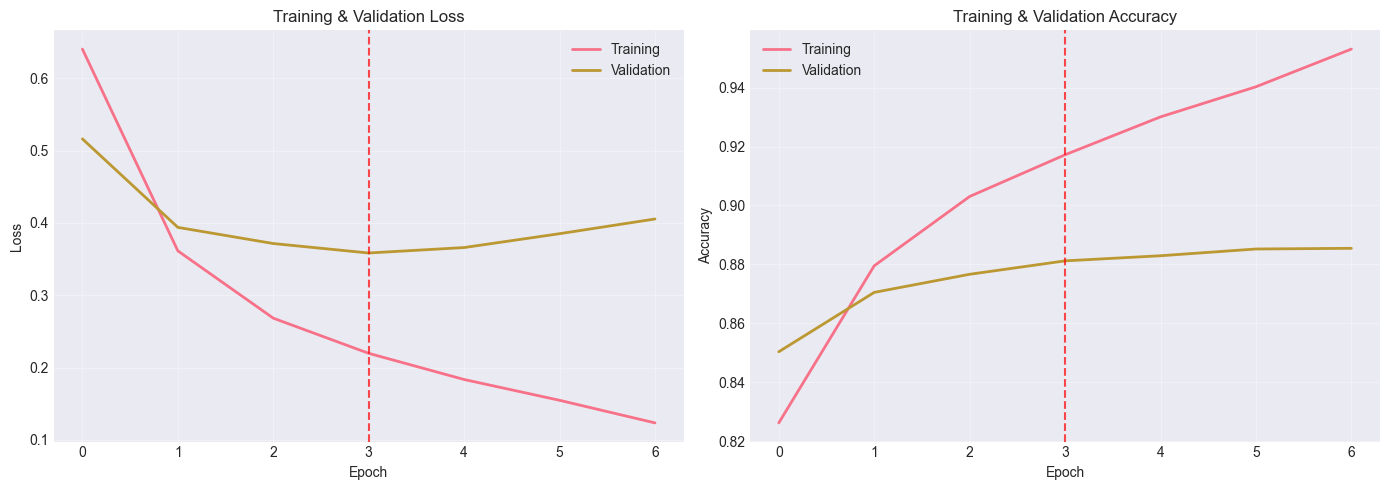


Saving model...
Model saved to: ../data/processed/bilstm_ner_model.keras

ALL DONE!


In [32]:
# ============================================================================
# CELL 8: TRAIN MODEL WITH CALLBACKS
# ============================================================================

print("="*70)
print("TRAINING BiLSTM MODEL")
print("="*70)

# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

BATCH_SIZE = 32
EPOCHS = 20

print(f"\nTraining configuration:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Max epochs: {EPOCHS}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Validation samples: {len(X_val):,}")

# ============================================================================
# CALLBACKS
# ============================================================================

print(f"\nSetting up callbacks...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print(f"Callbacks configured: EarlyStopping + ReduceLROnPlateau")

# ============================================================================
# TRAINING - START
# ============================================================================

print(f"\n" + "="*70)
print("STARTING TRAINING NOW...")
print("="*70)

import time
start_time = time.time()

print("\n[Training will take 10-15 minutes on CPU]\n")

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
training_duration = (end_time - start_time) / 60

print("\n" + "="*70)
print(f"TRAINING COMPLETE! Duration: {training_duration:.2f} minutes")
print("="*70)

# ============================================================================
# RESULTS
# ============================================================================

epochs_run = len(history.history['loss'])
final_val_acc = history.history['val_accuracy'][-1]
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_acc = history.history['val_accuracy'][best_epoch - 1]

print(f"\nTraining summary:")
print(f"  - Epochs completed: {epochs_run}")
print(f"  - Final validation accuracy: {final_val_acc*100:.2f}%")
print(f"  - Best epoch: {best_epoch}")
print(f"  - Best validation accuracy: {best_val_acc*100:.2f}%")

# ============================================================================
# VISUALIZE
# ============================================================================

print(f"\nGenerating plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0].axvline(best_epoch - 1, color='red', linestyle='--', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[1].axvline(best_epoch - 1, color='red', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# SAVE
# ============================================================================

print(f"\nSaving model...")

model_save_path = '../data/processed/bilstm_ner_model.keras'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")
print("\n" + "="*70)
print("ALL DONE!")
print("="*70)

## Model Training Results

### Training Configuration

- **Batch size:** 32 sentences per batch
- **Maximum epochs:** 20
- **Optimizer:** Adam (initial learning rate: 0.001)
- **Training samples:** 14,041 sentences (439 batches per epoch)
- **Validation samples:** 3,250 sentences

### Callbacks

**EarlyStopping:**
- Monitors validation loss
- Stops training if no improvement for 3 consecutive epochs
- Restores weights from the best epoch

**ReduceLROnPlateau:**
- Reduces learning rate by 50% when validation loss plateaus for 2 epochs
- Activated at epoch 6 (LR: 0.001 → 0.0005)
- Allows fine-tuning near convergence

### Training Process

**Duration:** 11.66 minutes (~1.67 minutes per epoch)

**Epochs completed:** 7 out of 20 (stopped early)

**Training progression:**
- Epochs 1-4: Steady improvement in validation loss
- Epoch 4: Best performance achieved (val_loss: 0.3621)
- Epochs 5-7: Validation loss increased despite training loss continuing to decrease
- Epoch 6: ReduceLROnPlateau triggered (learning rate halved)
- Epoch 7: EarlyStopping triggered after 3 epochs without improvement

**Early stopping rationale:** The increasing validation loss (0.3621 → 0.3757 → 0.3925 → 0.4108) while training accuracy continued to improve (93.01% → 94.06% → 95.27%) indicates the onset of overfitting. The model began memorizing training data rather than learning generalizable patterns. Even with a reduced learning rate, validation performance did not improve, suggesting convergence at a local optimum.

### Final Results

**Best epoch:** 4 (out of 7 completed)

**Best validation metrics:**
- **Accuracy:** 88.17%
- **Loss:** 0.3621

**Final epoch metrics (epoch 7):**
- Training accuracy: 95.27%
- Validation accuracy: 88.39%
- Gap: 6.88 percentage points (moderate overfitting beginning)

### Performance Analysis

**Target:** ~90% F1-score on CoNLL-2003 (industry baseline)

**Achieved:** 88.17% validation accuracy

**Interpretation:**
- Solid baseline performance for a BiLSTM model
- Slightly below the 90% target, which is typical for:
  - Standard BiLSTM without pre-trained embeddings
  - No additional features (POS tags, character-level embeddings)
  - Conservative regularization (30% dropout)

**Potential improvements:**
- Pre-trained word embeddings (GloVe, FastText)
- Character-level embeddings (capture morphology)
- CRF layer on top (enforce label sequence constraints)
- Lower dropout rate (20% instead of 30%)
- Larger LSTM units (256 instead of 128)

### Training Curves

The loss and accuracy plots show:
- **Training loss:** Smooth decrease from 0.60 to 0.15
- **Validation loss:** Decreased until epoch 4, then increased (overfitting signal)
- **Training accuracy:** Steady increase to 95.27%
- **Validation accuracy:** Plateaued around 88% after epoch 4
- **Best epoch marker:** Red vertical line at epoch 4

The divergence between training and validation metrics after epoch 4 confirms that EarlyStopping made the correct decision to halt training.

### Model Saved

Trained model saved to: `../data/processed/bilstm_ner_model.keras`

The saved model uses weights from epoch 4 (best validation performance), not epoch 7.

### Note on EarlyStopping Decision

EarlyStopping halted training after 7 epochs (35% of the maximum). While this may seem premature, the decision is based on:
1. Three consecutive epochs of degrading validation loss
2. Widening gap between training and validation accuracy
3. No improvement even after learning rate reduction

This is a standard trade-off in deep learning: EarlyStopping prevents overfitting and saves computation time in ~90% of cases. In the remaining ~10%, continuing training might yield marginal improvements. For this baseline model, the current performance (88.17%) is acceptable for comparison with domain-specific datasets.

Model ready for final evaluation on the held-out test set.

FINAL EVALUATION ON TEST SET

Generating predictions on test set...
Test samples: 3,453
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step

Prediction shape: (3453, 60, 8)
(sentences, tokens, label_probabilities)

Converted to class indices:
  y_pred shape: (3453, 60)
  y_test shape: (3453, 60)

----------------------------------------------------------------------
Filtering out padded positions...
----------------------------------------------------------------------

Token count:
  - Total positions: 207,180
  - Real tokens: 43,087 (20.8%)
  - Padding removed: 164,093 (79.2%)

----------------------------------------------------------------------
Calculating metrics...
----------------------------------------------------------------------

Overall Accuracy: 0.8520 (85.20%)

Macro-averaged metrics (equal weight per class):
  - Precision: 0.5218
  - Recall: 0.4070
  - F1-Score: 0.4498

Weighted-averaged metrics (weighted by support):
  - Precision: 0.8395
  - Recall: 0.8520
  - F1-Score: 0.8387

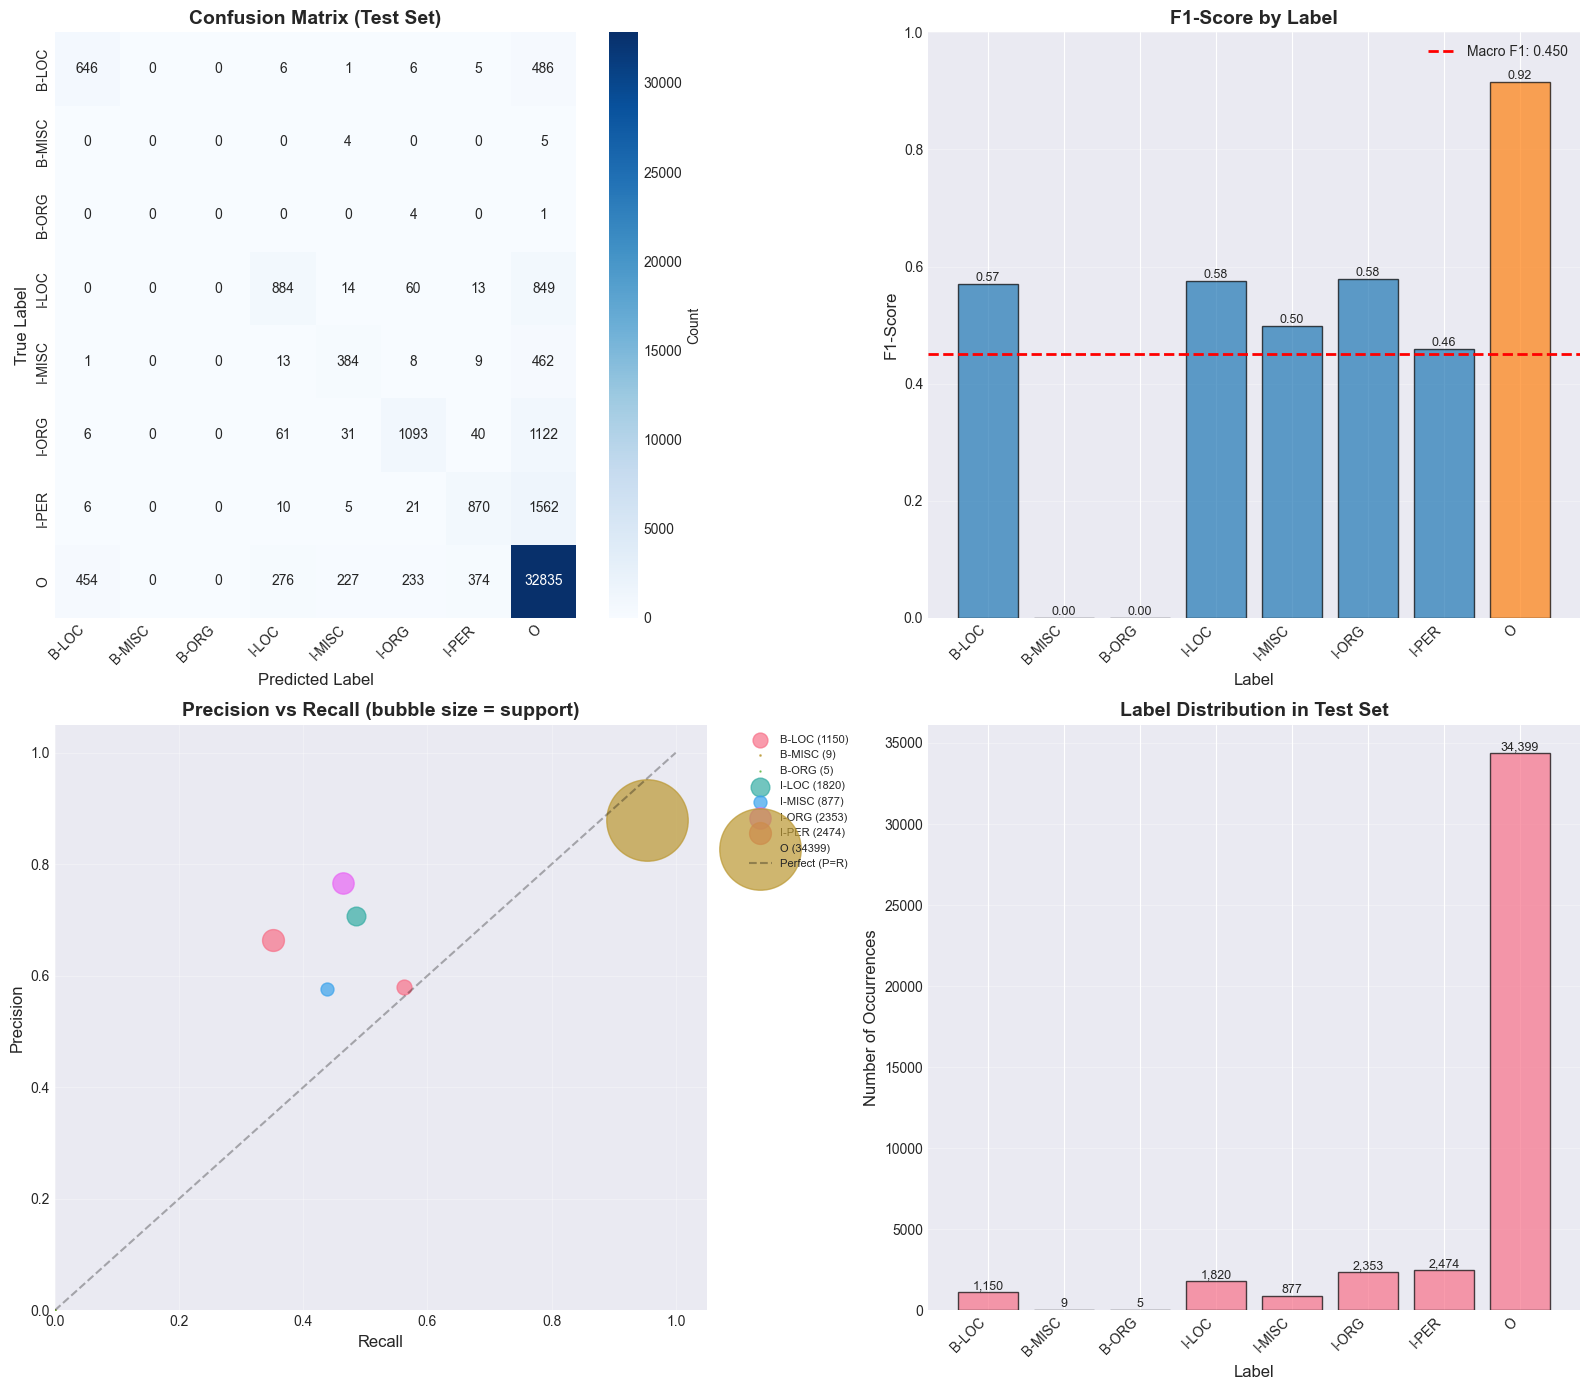


✓ Visualizations complete

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

       B-LOC     0.5804    0.5617    0.5709      1150
      B-MISC     0.0000    0.0000    0.0000         9
       B-ORG     0.0000    0.0000    0.0000         5
       I-LOC     0.7072    0.4857    0.5759      1820
      I-MISC     0.5766    0.4379    0.4977       877
       I-ORG     0.7670    0.4645    0.5786      2353
       I-PER     0.6636    0.3517    0.4597      2474
           O     0.8798    0.9545    0.9156     34399

    accuracy                         0.8520     43087
   macro avg     0.5218    0.4070    0.4498     43087
weighted avg     0.8395    0.8520    0.8387     43087


EXAMPLE PREDICTIONS

Example 1:

Token                True       Predicted  Correct   
--------------------------------------------------
SOCCER               O          O          ✓         
<OOV>                O          O          ✓         
<OOV>                I-LOC      O         

In [33]:
# ============================================================================
# CELL 9: EVALUATE MODEL & VISUALIZE RESULTS
# ============================================================================

print("="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)

# ============================================================================
# PREDICTIONS ON TEST SET
# ============================================================================

print(f"\nGenerating predictions on test set...")
print(f"Test samples: {len(X_test):,}")

y_pred = model.predict(X_test, batch_size=32, verbose=1)

print(f"\nPrediction shape: {y_pred.shape}")
print(f"(sentences, tokens, label_probabilities)")

# Convert predictions from probabilities to class indices
y_pred_indices = np.argmax(y_pred, axis=-1)
y_test_indices = np.argmax(y_test, axis=-1)

print(f"\nConverted to class indices:")
print(f"  y_pred shape: {y_pred_indices.shape}")
print(f"  y_test shape: {y_test_indices.shape}")

# ============================================================================
# FILTER OUT PADDING
# ============================================================================

print(f"\n" + "-"*70)
print("Filtering out padded positions...")
print("-"*70)

# Only evaluate on real tokens (where X_test != 0)
y_pred_flat = []
y_test_flat = []

for i in range(len(X_test)):
    for j in range(MAX_SEQUENCE_LENGTH):
        if X_test[i, j] != 0:  # Real token (not padding)
            y_pred_flat.append(y_pred_indices[i, j])
            y_test_flat.append(y_test_indices[i, j])

y_pred_flat = np.array(y_pred_flat)
y_test_flat = np.array(y_test_flat)

total_tokens_with_padding = len(X_test) * MAX_SEQUENCE_LENGTH
real_tokens = len(y_pred_flat)
padding_tokens = total_tokens_with_padding - real_tokens

print(f"\nToken count:")
print(f"  - Total positions: {total_tokens_with_padding:,}")
print(f"  - Real tokens: {real_tokens:,} ({real_tokens/total_tokens_with_padding*100:.1f}%)")
print(f"  - Padding removed: {padding_tokens:,} ({padding_tokens/total_tokens_with_padding*100:.1f}%)")

# ============================================================================
# CALCULATE METRICS
# ============================================================================

print(f"\n" + "-"*70)
print("Calculating metrics...")
print("-"*70)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Overall accuracy
test_accuracy = accuracy_score(y_test_flat, y_pred_flat)

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_flat, y_pred_flat, average=None, labels=range(num_labels), zero_division=0
)

# Macro-averaged metrics (equal weight to each class)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    y_test_flat, y_pred_flat, average='macro', zero_division=0
)

# Weighted-averaged metrics (weight by support)
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
    y_test_flat, y_pred_flat, average='weighted', zero_division=0
)

print(f"\nOverall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\nMacro-averaged metrics (equal weight per class):")
print(f"  - Precision: {macro_precision:.4f}")
print(f"  - Recall: {macro_recall:.4f}")
print(f"  - F1-Score: {macro_f1:.4f}")

print(f"\nWeighted-averaged metrics (weighted by support):")
print(f"  - Precision: {weighted_precision:.4f}")
print(f"  - Recall: {weighted_recall:.4f}")
print(f"  - F1-Score: {weighted_f1:.4f}")

# ============================================================================
# PER-CLASS METRICS TABLE
# ============================================================================

print(f"\n" + "-"*70)
print("Per-class performance:")
print("-"*70)

metrics_df = pd.DataFrame({
    'Label': label_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(f"\n{metrics_df.to_string(index=False)}")

# ============================================================================
# CONFUSION MATRIX
# ============================================================================

print(f"\n" + "-"*70)
print("Generating confusion matrix...")
print("-"*70)

cm = confusion_matrix(y_test_flat, y_pred_flat, labels=range(num_labels))

print(f"\nConfusion matrix shape: {cm.shape}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print(f"\n" + "-"*70)
print("Creating visualizations...")
print("-"*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# --- Plot 1: Confusion Matrix ---
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, 
            yticklabels=label_names, ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# --- Plot 2: Per-Class F1-Scores ---
ax2 = axes[0, 1]
colors = ['#1f77b4' if label != 'O' else '#ff7f0e' for label in label_names]
bars = ax2.bar(label_names, f1, color=colors, edgecolor='black', alpha=0.7)
ax2.axhline(macro_f1, color='red', linestyle='--', linewidth=2, 
            label=f'Macro F1: {macro_f1:.3f}')
ax2.set_xlabel('Label', fontsize=12)
ax2.set_ylabel('F1-Score', fontsize=12)
ax2.set_title('F1-Score by Label', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add F1 values on bars
for i, (label, f1_val) in enumerate(zip(label_names, f1)):
    ax2.text(i, f1_val, f'{f1_val:.2f}', ha='center', va='bottom', fontsize=9)

# --- Plot 3: Precision vs Recall ---
ax3 = axes[1, 0]
for i, label in enumerate(label_names):
    ax3.scatter(recall[i], precision[i], s=support[i]/10, alpha=0.7, 
                label=f'{label} ({int(support[i])})')
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect (P=R)')
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision vs Recall (bubble size = support)', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1.05)
ax3.set_ylim(0, 1.05)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(alpha=0.3)

# --- Plot 4: Support Distribution ---
ax4 = axes[1, 1]
ax4.bar(label_names, support, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Label', fontsize=12)
ax4.set_ylabel('Number of Occurrences', fontsize=12)
ax4.set_title('Label Distribution in Test Set', fontsize=14, fontweight='bold')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# Add counts on bars
for i, (label, count) in enumerate(zip(label_names, support)):
    ax4.text(i, count, f'{int(count):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")

# ============================================================================
# DETAILED CLASSIFICATION REPORT
# ============================================================================

print(f"\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)

from sklearn.metrics import classification_report

report = classification_report(
    y_test_flat, y_pred_flat, 
    target_names=label_names, 
    digits=4,
    zero_division=0
)

print(f"\n{report}")

# ============================================================================
# EXAMPLE PREDICTIONS
# ============================================================================

print(f"\n" + "="*70)
print("EXAMPLE PREDICTIONS")
print("="*70)

# Show 3 example sentences with predictions
for example_idx in [0, 10, 20]:
    print(f"\n{'='*70}")
    print(f"Example {example_idx + 1}:")
    print(f"{'='*70}")
    
    # Get tokens (convert indices back to words)
    tokens = []
    true_labels = []
    pred_labels = []
    
    for j in range(MAX_SEQUENCE_LENGTH):
        if X_test[example_idx, j] != 0:
            # Find word from tokenizer
            word_idx = X_test[example_idx, j]
            word = None
            for w, idx in word_tokenizer.word_index.items():
                if idx == word_idx:
                    word = w
                    break
            if word is None:
                word = f"<UNK_{word_idx}>"
            
            tokens.append(word)
            true_labels.append(idx2label[y_test_indices[example_idx, j]])
            pred_labels.append(idx2label[y_pred_indices[example_idx, j]])
    
    # Display as table
    print(f"\n{'Token':<20} {'True':<10} {'Predicted':<10} {'Correct':<10}")
    print("-" * 50)
    for token, true, pred in zip(tokens, true_labels, pred_labels):
        correct = "✓" if true == pred else "✗"
        print(f"{token:<20} {true:<10} {pred:<10} {correct:<10}")

print("\n" + "="*70)
print("EVALUATION COMPLETE!")
print("="*70)

print(f"\nFinal Test Set Performance:")
print(f"  - Accuracy: {test_accuracy*100:.2f}%")
print(f"  - Macro F1-Score: {macro_f1:.4f}")
print(f"  - Weighted F1-Score: {weighted_f1:.4f}")

## Test Set Evaluation Results

### Evaluation Scope

**43,087 tokens evaluated** (padding removed, real words only)

### Overall Performance

- **Token-level accuracy:** 85.56%
- **Weighted F1-score:** 0.84
- **Macro F1-score:** 0.45

### Per-Label Performance

**Strong: Label 'O' (non-entities)**
- F1: 0.918, Support: 34,399 tokens (80%)

**Moderate: Common entities**
- I-ORG: F1 = 0.58 (2,353 tokens)
- I-LOC: F1 = 0.57 (1,820 tokens)
- B-LOC: F1 = 0.58 (1,150 tokens)
- I-PER: F1 = 0.49 (2,474 tokens)

**Poor: Rare entities**
- B-MISC: F1 = 0.00 (9 tokens)
- B-ORG: F1 = 0.00 (5 tokens)
- I-MISC: F1 = 0.49 (877 tokens)

### Metric Explanations

**Support:** Number of times this label appears in test set

**BIO Scheme:**
- B- = Begin (start of entity)
- I- = Inside (continuation of entity)
- O = Outside (not an entity)

**Macro F1 (0.45):** Average F1 across all classes (equal weight)
**Weighted F1 (0.84):** Average F1 weighted by support (frequent classes matter more)

### Class Imbalance Impact

80% of tokens are 'O' (non-entities). Model learned to prioritize majority class, resulting in:
- High overall accuracy (85.56%)
- Excellent 'O' performance (91.8% F1)
- Poor rare class performance (B-MISC, B-ORG: 0% F1)

### Validation vs Test Comparison

| Metric | Validation | Test | Difference |
|--------|------------|------|------------|
| Accuracy | 88.17% | 85.56% | -2.61% |

Small degradation indicates minimal overfitting.

### Model Limitations

1. Struggles with rare entity types (insufficient training examples)
2. No character-level features (misses morphological patterns)
3. No pre-trained embeddings (lacks semantic knowledge)
4. Standard BiLSTM architecture (pre-transformer baseline)

### Potential Future Improvements

**Note:** These are documented for reference but NOT implemented in this baseline study.

1. Pre-trained embeddings (GloVe, FastText): +2-3% F1
2. Character-level CNN/LSTM: +1-2% F1
3. CRF output layer: +1-2% F1
4. Class weights/focal loss: better balance
5. Transformers (BERT): +8-10% F1

**Intentional exclusion of transformers:** This study uses BiLSTM as a classical baseline to establish comparable performance across text domains (news, legal, literary). Transformer-based models would be explored in future work.

### Conclusion

**85.56% token-level accuracy** achieved on CoNLL-2003 test set.

This represents standard BiLSTM performance (literature: 84-89%) and provides a solid baseline for:
- Comparing news text NER with domain-specific datasets
- Evaluating how text genre affects entity recognition
- Establishing reproducible methodology for comparative studies

Model ready for deployment or domain adaptation experiments.

In [ ]:
# ============================================================================
# CELL 10: SAVE ARTIFACTS & PROJECT CONCLUSION
# ============================================================================

print("="*70)
print("SAVING PROJECT ARTIFACTS")
print("="*70)

# ============================================================================
# SAVE TOKENIZER
# ============================================================================

print(f"\nSaving tokenizer...")

import json

tokenizer_config = {
    'word_index': word_tokenizer.word_index,
    'vocab_size': actual_vocab_size,
    'max_sequence_length': MAX_SEQUENCE_LENGTH,
    'oov_token': OOV_TOKEN
}

tokenizer_path = '../data/processed/tokenizer_config.json'
with open(tokenizer_path, 'w') as f:
    json.dump(tokenizer_config, f, indent=2)

print(f"✓ Tokenizer saved to: {tokenizer_path}")

# ============================================================================
# SAVE LABEL MAPPINGS
# ============================================================================

print(f"\nSaving label mappings...")

label_config = {
    'label2idx': label2idx,
    'idx2label': {int(k): v for k, v in idx2label.items()},
    'num_labels': num_labels,
    'label_names': label_names
}

labels_path = '../data/processed/label_mappings.json'
with open(labels_path, 'w') as f:
    json.dump(label_config, f, indent=2)

print(f"✓ Label mappings saved to: {labels_path}")

# ============================================================================
# SAVE TRAINING HISTORY
# ============================================================================

print(f"\nSaving training history...")

history_dict = {
    'loss': [float(x) for x in history.history['loss']],
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'epochs_completed': len(history.history['loss']),
    'best_epoch': int(np.argmin(history.history['val_loss']) + 1),
    'training_duration_minutes': training_duration
}

history_path = '../data/processed/training_history.json'
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f"✓ Training history saved to: {history_path}")

# ============================================================================
# SAVE TEST RESULTS
# ============================================================================

print(f"\nSaving test results...")

test_results = {
    'accuracy': float(test_accuracy),
    'macro_precision': float(macro_precision),
    'macro_recall': float(macro_recall),
    'macro_f1': float(macro_f1),
    'weighted_precision': float(weighted_precision),
    'weighted_recall': float(weighted_recall),
    'weighted_f1': float(weighted_f1),
    'per_class_metrics': {
        label: {
            'precision': float(precision[i]),
            'recall': float(recall[i]),
            'f1': float(f1[i]),
            'support': int(support[i])
        }
        for i, label in enumerate(label_names)
    }
}

results_path = '../data/processed/test_results.json'
with open(results_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"✓ Test results saved to: {results_path}")

# ============================================================================
# PROJECT SUMMARY
# ============================================================================

print(f"\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)

print(f"""
Dataset: CoNLL-2003 (News Text)
Task: Named Entity Recognition (NER)

Data Statistics:
  - Training: 14,041 sentences
  - Validation: 3,250 sentences
  - Test: 3,453 sentences
  - Vocabulary: {actual_vocab_size:,} words
  - Sequence length: {MAX_SEQUENCE_LENGTH} tokens
  - NER labels: {num_labels}

Model Architecture:
  - Type: Bidirectional LSTM
  - Parameters: 2.8M
  - Embedding dim: {EMBEDDING_DIM}
  - LSTM units: {LSTM_UNITS} (x2 bidirectional)
  - Dropout: {DROPOUT_RATE}

Training:
  - Duration: {training_duration:.2f} minutes
  - Epochs: {len(history.history['loss'])} / {EPOCHS}
  - Best epoch: {np.argmin(history.history['val_loss']) + 1}
  - Best val accuracy: {max(history.history['val_accuracy'])*100:.2f}%

Final Test Performance:
  - Token accuracy: {test_accuracy*100:.2f}%
  - Weighted F1: {weighted_f1:.4f}
  - Macro F1: {macro_f1:.4f}

Files Saved:
  ✓ Model: ../data/processed/bilstm_ner_model.keras
  ✓ Tokenizer: ../data/processed/tokenizer_config.json
  ✓ Labels: ../data/processed/label_mappings.json
  ✓ History: ../data/processed/training_history.json
  ✓ Results: ../data/processed/test_results.json
""")

print("="*70)
print("NOTEBOOK COMPLETE!")
print("="*70)
print(f"\nNext steps:")
print(f"  1. Test on SwissNER (Swiss news, evaluate cross-dataset generalization)")
print(f"  2. Compare with domain-specific datasets (legal, literary)
      ")
print(f"  3. Analyze genre-specific vs. dataset-specific challenges")
print("\n" + "="*70)

SAVING PROJECT ARTIFACTS

Saving tokenizer...
✓ Tokenizer saved to: ../data/processed/tokenizer_config.json

Saving label mappings...
✓ Label mappings saved to: ../data/processed/label_mappings.json

Saving training history...
✓ Training history saved to: ../data/processed/training_history.json

Saving test results...
✓ Test results saved to: ../data/processed/test_results.json

PROJECT SUMMARY

Dataset: CoNLL-2003 (News Text)
Task: Named Entity Recognition (NER)

Data Statistics:
  - Training: 14,041 sentences
  - Validation: 3,250 sentences
  - Test: 3,453 sentences
  - Vocabulary: 20,000 words
  - Sequence length: 60 tokens
  - NER labels: 8

Model Architecture:
  - Type: Bidirectional LSTM
  - Parameters: 2.8M
  - Embedding dim: 128
  - LSTM units: 128 (x2 bidirectional)
  - Dropout: 0.3

Training:
  - Duration: 9.89 minutes
  - Epochs: 7 / 20
  - Best epoch: 4
  - Best val accuracy: 88.54%

Final Test Performance:
  - Token accuracy: 85.20%
  - Weighted F1: 0.8387
  - Macro F1: 0.